In [1]:
!pip install neuralprophet prophet==1.0 pystan==2.19.1.1  

You should consider upgrading via the '/Users/catdev/.pyenv/versions/3.8.16/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
from neuralprophet import NeuralProphet
from prophet import Prophet
from matplotlib import pyplot as plt
import pickle
import asyncio
from datetime import datetime
import json


/Users/catdev/.pyenv/versions/3.8.16/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
weatherData = pd.read_csv('weather_records.csv')
weatherData['createdAt'] = pd.to_datetime(weatherData['createdAt']).dt.tz_localize(None)
# weatherData = weatherData[weatherData['createdAt'] < weatherData['createdAt'].max() - pd.DateOffset(days=3)]
weatherData['weatherRecord'] = weatherData['weatherRecord'].apply(lambda x: json.loads(x))
weatherData.head()

weatherDataWithoutLast7Days = pd.read_csv('weather_records.csv')
weatherDataWithoutLast7Days['createdAt'] = pd.to_datetime(weatherDataWithoutLast7Days['createdAt']).dt.tz_localize(None)
weatherDataWithoutLast7Days = weatherDataWithoutLast7Days[weatherDataWithoutLast7Days['createdAt'] < weatherDataWithoutLast7Days['createdAt'].max() - pd.DateOffset(days=7)]
weatherDataWithoutLast7Days['weatherRecord'] = weatherDataWithoutLast7Days['weatherRecord'].apply(lambda x: json.loads(x))
weatherDataWithoutLast7Days.head()

,id,createdAt,weatherRecord,weatherStationId
480935,596388,2023-05-06 23:15:28.042,"{'humidityFromDTH22': 56.29999924, 'pressureFr...",b92047e5-b481-4374-9fde-12eb295bf373
480936,596387,2023-05-06 23:15:26.004,"{'humidityFromDTH22': 56.29999924, 'pressureFr...",b92047e5-b481-4374-9fde-12eb295bf373
480937,596386,2023-05-06 23:15:23.988,"{'humidityFromDTH22': 56.29999924, 'pressureFr...",b92047e5-b481-4374-9fde-12eb295bf373
480938,596385,2023-05-06 23:15:21.974,"{'humidityFromDTH22': 56.29999924, 'pressureFr...",b92047e5-b481-4374-9fde-12eb295bf373
480939,596384,2023-05-06 23:15:19.958,"{'humidityFromDTH22': 56.29999924, 'pressureFr...",b92047e5-b481-4374-9fde-12eb295bf373


In [30]:
print(len(weatherData))
print(len(weatherDataWithoutLast7Days))

1077323
596388


In [5]:
weatherData.dtypes
# df['weatherRecord'].apply(lambda x: x['humidityFromDTH22'])

id                           int64
createdAt           datetime64[ns]
weatherRecord               object
weatherStationId            object
dtype: object

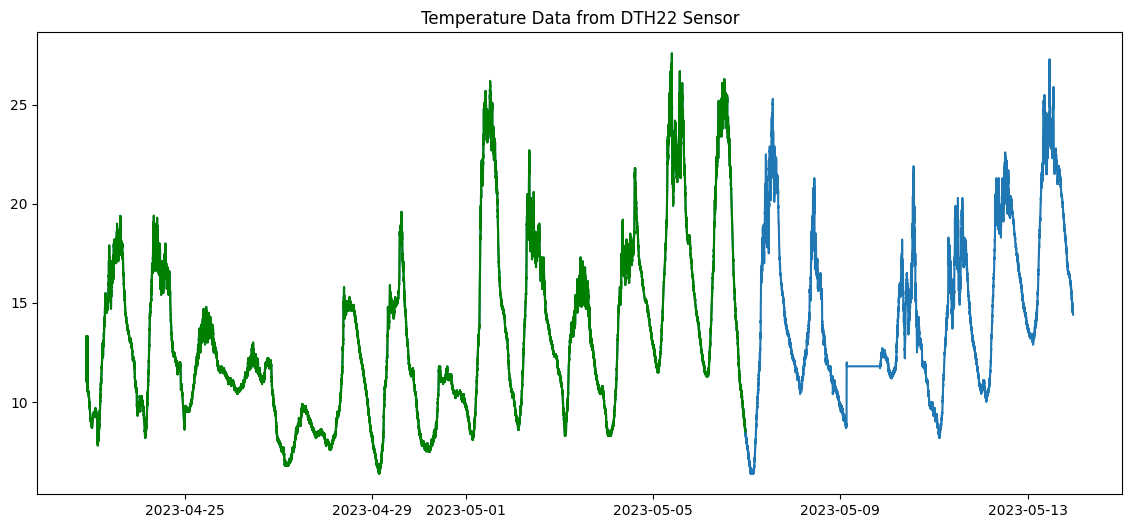

In [31]:
# df['weatherRecord'].apply(lambda x: x['analogSignalFromRainSensor'] if x['analogSignalFromRainSensor'] <= 1024 else None)
# plt.plot(df['id'], df['weatherRecord'].apply(lambda x: x['analogSignalFromRainSensor'] if x['analogSignalFromRainSensor'] <= 1024 else None))
# plt.plot(df['id'], df['weatherRecord'].apply(lambda x: x['pressureFromBMP180']))
# plt.plot(df['id'], df['weatherRecord'].apply(lambda x: x['temperatureFromDTH22'] if x['temperatureFromDTH22'] <= 200000 else None))
plt.figure(figsize=(14, 6))
plt.plot(weatherData['createdAt'], weatherData['weatherRecord'].apply(lambda x: x['temperatureFromDTH22'] if x['temperatureFromDTH22'] <= 200000 else None))
plt.plot(weatherDataWithoutLast7Days['createdAt'], weatherDataWithoutLast7Days['weatherRecord'].apply(lambda x: x['temperatureFromDTH22'] if x['temperatureFromDTH22'] <= 200000 else None), color='green')
plt.title("Temperature Data from DTH22 Sensor")
plt.show()

In [47]:
data = pd.DataFrame({'ds': weatherDataWithoutLast7Days['createdAt'], 'y': weatherDataWithoutLast7Days['weatherRecord'].apply(lambda x: x['humidityFromDTH22'] if x['humidityFromDTH22'] <= 100 else None) })
# data = pd.DataFrame({'ds': df['createdAt'], 'y': df['weatherRecord'].apply(lambda x: x['pressureFromBMP180'] if x['pressureFromBMP180'] <= 200000 else None)})
data = data.drop_duplicates()
data = data.dropna()

len(weatherDataWithoutLast7Days)



596388

# Train modal

In [53]:


m = NeuralProphet(
    growth="linear",  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints_range=0.95,
    trend_reg_threshold=False,
    #yearly_seasonality="auto",
    #weekly_seasonality="auto",
    #daily_seasonality="auto",
    seasonality_mode="additive",
    # trend_reg=5,
    # yearly_seasonality=True,
    # weekly_seasonality=True,
    # daily_seasonality=False,
    # seasonality_reg=0,
    # n_forecasts=1,
    # n_lags=7,
    # batch_size=32,
    # num_hidden_layers=2,
    # d_hidden=4,     # Dimension of hidden layers of AR-Net
    # ar_sparsity=None,  # Sparcity in the AR coefficients
    epochs=10,
    #learning_rate=0.1,
    loss_func="Huber",
    normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True
)


m.set_plotting_backend("matplotlib")  # Use matplotlib due to #1235
metrics = m.fit(data, freq='10min', epochs=5)


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 2019L corresponds to 4.622% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq 10min. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
WAR

Epoch 5: 100%|█| 5/5 [00:32<00:00,  6.48s/it, loss=0.00462, v_num=29, MAE=7.390, RMSE=9.050, Loss=0.00452, RegLoss


In [54]:
future = m.make_future_dataframe(data, periods=1000)
forecast = m.predict(future)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency -2019L corresponds to 4.622% of the data.
WARNING - (NP.df_utils._infer_frequency) - Dataframe has multiple frequencies. It will be resampled according to given freq 10min. Ignore message if actual frequency is any of the following:  SM, BM, CBM, SMS, BMS, CBMS, BQ, BQS, BA, or, BAS.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 10T corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 10min
INFO - (NP.df_utils._infer_frequency) - Major frequency 10T corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 10min


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 298.87it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_weekly,season_daily
0,2023-05-06 23:25:28.042,None,54.341953,43.965271,1.100114,9.276570
1,2023-05-06 23:35:28.042,None,54.940723,43.948639,1.184891,9.807191
2,2023-05-06 23:45:28.042,None,55.544209,43.932011,1.271901,10.340297
3,2023-05-06 23:55:28.042,None,56.146397,43.915382,1.361122,10.869894
4,2023-05-07 00:05:28.042,None,56.741497,43.898750,1.452531,11.390216


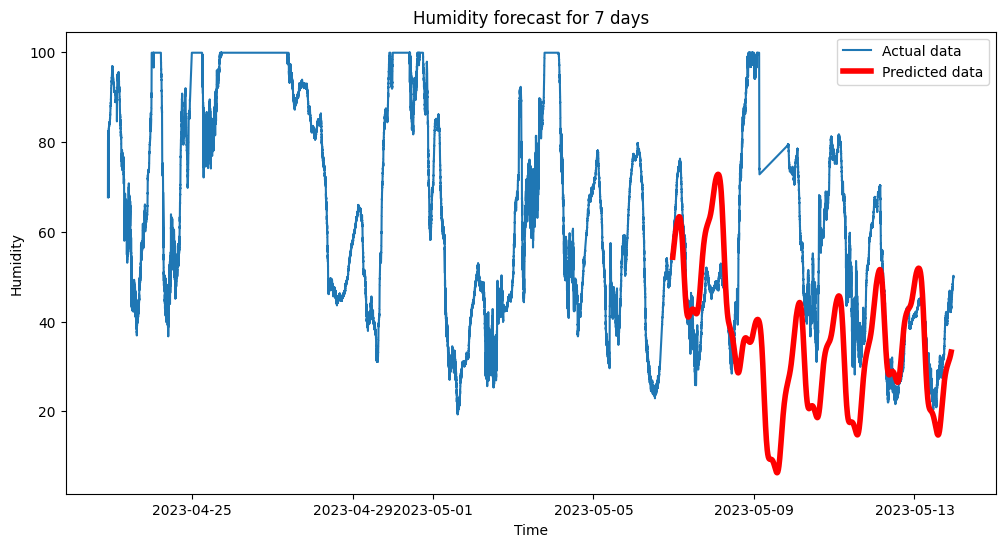

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))

# ax.plot(data['ds'], data['y'], label='Actual data')

plt.plot(weatherData['createdAt'], weatherData['weatherRecord'].apply(lambda x: x['humidityFromDTH22'] if x['humidityFromDTH22'] <= 200000 else None), label='Actual data')

ax.plot(forecast['ds'], forecast['yhat1'], label='Predicted data', linewidth=4, color='red')


ax.set_xlabel('Time')
ax.set_ylabel('Humidity')
ax.set_title('Humidity forecast for 7 days')

ax.legend()
plt.show()


TypeError: cannot perform __rtruediv__ with this index type: DatetimeArray

# Train modal with Prophet

# Save modal

In [ ]:
with open('model.pkl', 'wb') as f:
    pickle.dump(m,f)

# Open modal

In [ ]:
with open('model.pkl', 'rb') as f:
    m = pickle.load(f)
m.restore_trainer()

In [ ]:
future = m.make_future_dataframe(data, periods=1000)
# future['cap'] = 1024
# future['floor'] = 0
forecast = m.predict(future)
forecast.head()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(data['ds'], data['y'], label='Actual data')

ax.plot(forecast['ds'], forecast['yhat1'], label='Predicted data')

ax.set_xlabel('Time')
ax.set_ylabel('Pressure')
ax.set_title('Data Frames Comparison')

ax.legend()
plt.show()